In [55]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-12-31'
TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-09-01'

TRAINED_PPO = "/agent_opt_ppo_update_test"

GRAPH_TITLE = "PPO Trained 2009-2021, 1500 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4014, 8)


# PPO On portfolio Opt

In [56]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime



environment_ppo = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.42402121 0.40301045 0.38364201 0.39324507 0.35187325 0.43326432
 0.30897601 0.30356617 0.34293207 0.32643593 0.36911039 0.38476772
 0.37099254 0.49853178 0.65860595 0.46992023 0.43939082 0.49490263
 0.7301951  0.46887811 0.34986369 0.3445898  0.36286662 0.33465194
 0.31349225 0.30366356 0.28928088 0.36874192 0.40041449 0.34974844
 0.25374176 0.24826334 0.28239958 0.33589899 0.36994677 0.36526535
 0.57278913 0.3732395  0.38574815 0.33874655 0.32353034 0.31116778
 0.33981302 0.39127608 0.53221149 0.37113213 0.42748722 0.39351331
 0.44124455 0.37725741 0.41514333 0.30685403 0.50122148 0.3888112
 0.33086412 0.39794718 0.36576125 0.32686366 0.36673722 0.40820075
 0.37591378 0.41818324 0.31957979 0.31031558 0.29787105 0.36140855
 0.31488621 0.3107502  0.2931

In [57]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 

In [58]:
# from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1119118.625
Final accumulative portfolio value: 1.119118625
Maximum DrawDown: -0.24769237499999996
Sharpe ratio: 0.32702747194209847
Total commission cost: 5438.005264516803
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2022-01-03
1         9.975328e+05 2022-01-04
2         9.896542e+05 2022-01-05
3         9.845239e+05 2022-01-06
4         9.857093e+05 2022-01-07
..                 ...        ...
664       1.095515e+06 2024-08-26
665       1.097193e+06 2024-08-27
666       1.088472e+06 2024-08-28
667       1.100759e+06 2024-08-29
668       1.119119e+06 2024-08-30

[669 rows x 2 columns]


In [59]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2022-01-03 00:00:00')

# Porfolio Baselines

In [60]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment_benchmark = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [61]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmark.reset()
agent_crp = DRLStableAgent(env = environment_benchmark)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmark)
CRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1112971.0
Final accumulative portfolio value: 1.112971
Maximum DrawDown: -0.29080649999999997
Sharpe ratio: 0.2972536130797917
Total commission cost: 6345.55598815938
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2022-01-03
1         9.971561e+05 2022-01-04
2         9.885992e+05 2022-01-05
3         9.829753e+05 2022-01-06
4         9.841952e+05 2022-01-07
..                 ...        ...
664       1.084072e+06 2024-08-26
665       1.085835e+06 2024-08-27
666       1.075456e+06 2024-08-28
667       1.089759e+06 2024-08-29
668       1.112971e+06 2024-08-30

[669 rows x 2 columns]


In [62]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmark.reset()
agent_bah = DRLStableAgent(env = environment_benchmark)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmark)
BAH_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1129724.5
Final accumulative portfolio value: 1.1297245
Maximum DrawDown: -0.29067875
Sharpe ratio: 0.33128208325279873
Total commission cost: 6345.55598815938
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2022-01-03
1         9.971561e+05 2022-01-04
2         9.886889e+05 2022-01-05
3         9.831727e+05 2022-01-06
4         9.844367e+05 2022-01-07
..                 ...        ...
664       1.108921e+06 2024-08-26
665       1.111631e+06 2024-08-27
666       1.103762e+06 2024-08-28
667       1.116281e+06 2024-08-29
668       1.129724e+06 2024-08-30

[669 rows x 2 columns]


In [63]:
# OLMAR

OLMAR_results = {
    "test": {},
}

# OLMAR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }


environment_benchmark.reset()
agent_olmar = DRLStableAgent(env = environment_benchmark)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmark)
OLMAR_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 621020.0
Final accumulative portfolio value: 0.62102
Maximum DrawDown: -0.5538391303034144
Sharpe ratio: -0.2891260481900669
Total commission cost: 587586.6990149448
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2022-01-03
1           9.971561e+05 2022-01-04
2           9.928957e+05 2022-01-05
3           9.848339e+05 2022-01-06
4           1.004219e+06 2022-01-07
..                   ...        ...
664         6.169631e+05 2024-08-26
665         6.151242e+05 2024-08-27
666         6.010257e+05 2024-08-28
667         6.169631e+05 2024-08-29
668         6.210200e+05 2024-08-30

[669 rows x 2 columns]


In [64]:
# RMR

RMR_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_rmr = DRLStableAgent(env = environment_benchmark)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmark)
RMR_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 771871.0
Final accumulative portfolio value: 0.771871
Maximum DrawDown: -0.42331313809909776
Sharpe ratio: -0.31359598257512783
Total commission cost: 626815.4907835792
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2022-01-03
1         9.971561e+05 2022-01-04
2         9.928957e+05 2022-01-05
3         9.848339e+05 2022-01-06
4         1.004219e+06 2022-01-07
..                 ...        ...
664       7.598776e+05 2024-08-26
665       7.608771e+05 2024-08-27
666       7.603774e+05 2024-08-28
667       7.637754e+05 2024-08-29
668       7.718710e+05 2024-08-30

[669 rows x 2 columns]


In [65]:
# BNN

BNN_results = {
    "test": {},
}

# RMR_model_kwargs = {
#     "eps": 60,
#     "window": 100
# }

environment_benchmark.reset()
agent_bnn = DRLStableAgent(env = environment_benchmark)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmark)
BNN_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 839035.5
Final accumulative portfolio value: 0.8390355
Maximum DrawDown: -0.41575501249709645
Sharpe ratio: -0.17952560418724395
Total commission cost: 665789.4940842093
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2022-01-03
1         1000000.0000 2022-01-04
2         1000000.0000 2022-01-05
3         1000000.0000 2022-01-06
4         1000000.0000 2022-01-07
..                 ...        ...
664        825998.5625 2024-08-26
665        827084.9375 2024-08-27
666        826541.7500 2024-08-28
667        830235.5000 2024-08-29
668        839035.5000 2024-08-30

[669 rows x 2 columns]


In [66]:
# SCRP

HISTORY_START_DATE = TRAIN_START_DATE
HISTORY_END_DATE = TRAIN_END_DATE

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = PORT).fetch_data()


history_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(history_df)

SCRP_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

environment_benchmark.reset()
agent_scrp = DRLStableAgent(env = environment_benchmark)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmark)
SCRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.0420757  0.03314671 0.03177728]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Se

Shape of DataFrame:  (19266, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 34645192.0
Final accumulative portfolio value: 34.645192
Maximum DrawDown: -0.4379717401967733
Sharpe ratio: 1.1275154957187863
Total commission cost: 15542.318534534075
hit end!


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1277377.75
Final accumulative portfolio value: 1.27737775
Maximum DrawDown: -0.309128125
Sharpe ratio: 0.4693548278136206
Total commission cost: 665789.4999869603
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2022-01-03
1          9.873083e+05 2022-01-04
2          9.610460e+05 2022-01-05
3          9.450029e+05 2022-01-06
4          9.459369e+05 2022-01-07
..                  ...        ...
664        1.267226e+06 2024-08-26
665        1.271967e+06 2024-08-27
666        1.263377e+06 2024-08-28
667        1.281784e+06 2024-08-29
668        1.277378e+06 2024-08-30

[669 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [67]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmark.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmark)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmark)
BCRP_results["test"]["value"] = environment_benchmark._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmark._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_ppo_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_ppo_opt.loc[len(df_ppo_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1667827.0
Final accumulative portfolio value: 1.667827
Maximum DrawDown: -0.2573967260308019
Sharpe ratio: 1.0251549068495889
Total commission cost: 665789.4999935551
hit end!
     bcrp_opt_net_worth       Date
0           1000000.000 2022-01-03
1            981680.125 2022-01-04
2            994953.375 2022-01-05
3            992188.125 2022-01-06
4           1001659.250 2022-01-07
..                  ...        ...
664         1641912.375 2024-08-26
665         1644071.875 2024-08-27
666         1642992.125 2024-08-28
667         1650334.500 2024-08-29
668         1667827.000 2024-08-30

[669 rows x 2 columns]


# Stock environment optimization algorithm

In [68]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_ppo_date.loc[0,'Date'],
        end = df_ppo_date.loc[len(df_ppo_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_ppo_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (668, 8)
Annual return          0.047127
Cumulative returns     0.129834
Annual volatility      0.150222
Sharpe ratio           0.382107
Calmar ratio           0.214794
Stability              0.563509
Max drawdown          -0.219408
Omega ratio            1.067498
Sortino ratio          0.541519
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041697
Daily value at risk   -0.018698
dtype: float64
df_dji:            date           dji
0   2022-01-03  1.000000e+06
1   2022-01-04  1.005866e+06
2   2022-01-05  9.951360e+05
3   2022-01-06  9.904718e+05
4   2022-01-07  9.903404e+05
..         ...           ...
664 2024-08-26  1.127250e+06
665 2024-08-27  1.127523e+06
666 2024-08-28  1.123175e+06
667 2024-08-29  1.129834e+06
668 2024-08-30           NaN

[669 rows x 2 columns]
df_dji:                       dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05

# Compare all results

In [69]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')


# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')




print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2024-08-26  1.127250e+06
2024-08-27  1.127523e+06
2024-08-28  1.123175e+06
2024-08-29  1.129834e+06
2024-08-30           NaN

[669 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2022-01-03         1000000.000       1.000000e+06   
1         9.971561e+05 2022-01-04          981680.125       9.971561e+05   
2         9.885992e+05 2022-01-05          994953.375       9.886889e+05   
3         9.829753e+05 2022-01-06          992188.125       9.831727e+05   
4         9.841952e+05 2022-01-07         1001659.250       9.844367e+05   
..                 ...        ...                 ...                ...   
664       1.084072e+06 2024-08-26         1641912.375       1.108921e+06   
665       1.085835e+06 2024-08-27         1

# Baseline CRP in the environment

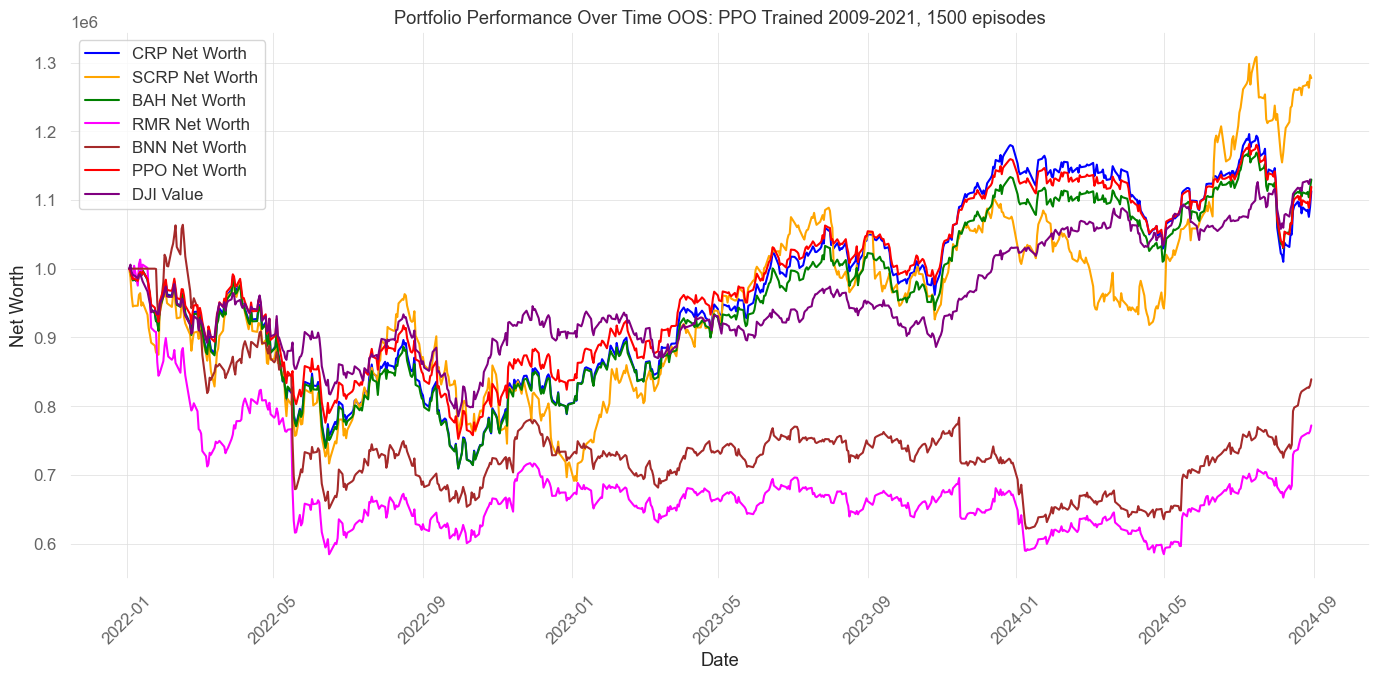

In [70]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'CRP Net Worth': 'blue',
    'BAH Net Worth': 'green',
    'PPO Net Worth': 'red',
    'DJI Value': 'purple',
    'SCRP Net Worth': 'orange',
    'OLMAR Net Worth': 'cyan',
    'RMR Net Worth': 'magenta',
    'BNN Net Worth': 'brown'
}




plt.figure(figsize=(14, 7))
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth', color=color_map['CRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP Net Worth', color=color_map['SCRP Net Worth'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth', color=color_map['BAH Net Worth'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth', color=color_map['OLMAR Net Worth'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR Net Worth', color=color_map['RMR Net Worth'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN Net Worth', color=color_map['BNN Net Worth'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Net Worth', color=color_map['PPO Net Worth'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI Value', color=color_map['DJI Value'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1129724.5,
 'BCRP OPT': 1667827.0,
 'BNN': 839035.5,
 'CRP': 1112971.0,
 'OLMAR': 621020.0,
 'PPO': 1119118.625,
 'RMR': 771871.0,
 'SCRP': 1277377.75}


In [72]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()

merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.2303876682377809,
 'BCRP': 0.9306099155468333,
 'BNN': -0.2683696969160527,
 'CRP': 0.20201979362844422,
 'OLMAR': -0.3430617158135038,
 'PPO': 0.21507060566899813,
 'RMR': -0.4016639840281932,
 'SCRP': 0.39813580929646974}


In [73]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.29067875,
 'BCRP': -0.2573967260308019,
 'BNN': -0.41575501249709645,
 'CRP': -0.29080649999999997,
 'OLMAR': -0.5538391303034144,
 'PPO': -0.24769237499999996,
 'RMR': -0.42331313809909776,
 'SCRP': -0.309128125}


In [74]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq      df        F    PR(>F)
Portfolio  2.742284e-07     1.0  0.00195  0.964784
Residual   1.875941e-01  1334.0      NaN       NaN


In [75]:
merged_df['ppo_opt_daily_return']

0           NaN
1     -0.002467
2     -0.007898
3     -0.005184
4      0.001204
         ...   
664   -0.003573
665    0.001532
666   -0.007948
667    0.011289
668    0.016679
Name: ppo_opt_daily_return, Length: 669, dtype: float64

In [76]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1     -0.002844
2     -0.008491
3     -0.005579
4      0.001286
5     -0.003418
         ...   
664   -0.001942
665    0.002444
666   -0.007079
667    0.011342
668    0.012043
Name: BAH_opt_daily_return, Length: 668, dtype: float64
t-statistic: -0.04415954186776013
p-value: 0.964783840407804
